# Data Preprocessing – WAID Dataset

## Objective

This notebook defines and validates the preprocessing pipeline applied to the
WAID dataset prior to model training. The preprocessing steps are designed to
address the challenges identified during data exploration, including small
object sizes, varying illumination conditions, and heterogeneous backgrounds.


In [ ]:
# Core
import os
import numpy as np

# Computer vision
import cv2

# Visualization
import matplotlib.pyplot as plt

# Augmentation
import albumentations as A

#Utilities
from collections import defaultdict

c:\Users\lena\miniconda3\envs\rag-lab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PROJECT_ROOT = os.path.abspath("..")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw")

IMAGE_DIR = os.path.join(RAW_DATA_DIR, "images")
ANNOTATION_DIR = os.path.join(RAW_DATA_DIR, "annotations")

CLASSES_PATH = os.path.join(DATA_DIR, "classes.txt")

with open(CLASSES_PATH) as f:
    CLASS_NAMES = [line.strip() for line in f if line.strip()]

SPLITS = ["train", "valid", "test"]

print("Classes:", CLASS_NAMES)

Classes: ['sheep', 'cattle', 'seal', 'kiang', 'camelus', 'zebra']


In [3]:
image_files = defaultdict(list)
annotation_files = defaultdict(list)

for split in SPLITS:
    image_split_dir = os.path.join(IMAGE_DIR, split)
    ann_split_dir = os.path.join(ANNOTATION_DIR, split)

    image_files[split] = sorted([
        f for f in os.listdir(image_split_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])

    annotation_files[split] = sorted([
        f for f in os.listdir(ann_split_dir)
        if f.lower().endswith(".txt")
    ])


## Image Resizing

All images are resized to a fixed resolution prior to training in order to
ensure consistent input dimensions across models. A resolution of **640×640**
is adopted for YOLO-based experiments, balancing detection performance and
computational efficiency.


## Normalization

Images are normalized to the [0, 1] range. For models pretrained on ImageNet,
mean–standard deviation normalization is applied during training.


In [4]:
def preprocess_image(image, size=(640, 640)):
    image = cv2.resize(image, size)
    image = image.astype(np.float32) / 255.0
    return image

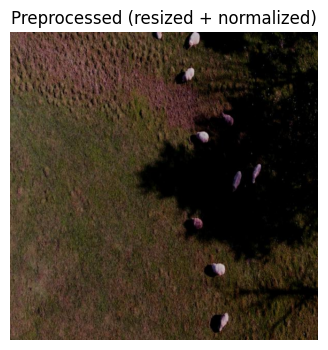

In [6]:
split = "train"
img_name = image_files[split][-100]

img_path = os.path.join(IMAGE_DIR, split, img_name)
ann_path = os.path.join(ANNOTATION_DIR, split, img_name.replace(".jpg", ".txt"))

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

processed_image = preprocess_image(image)

plt.figure(figsize=(4, 4))
plt.imshow(processed_image)
plt.title("Preprocessed (resized + normalized)")
plt.axis("off")
plt.show()


## Data Augmentation

Data augmentation is employed to improve robustness to variations in
illumination, viewpoint, scale, and background complexity commonly encountered
in drone imagery.


In [ ]:
train_transforms = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ShiftScaleRotate(
                shift_limit=0.05,
                scale_limit=0.2,
                rotate_limit=15,
                p=0.4
            ),
            A.MotionBlur(p=0.2),
        ],
        bbox_params=A.BboxParams(
            format="yolo",
            label_fields=["class_labels"],
            clip=True,
            min_visibility=0.2,
            check_each_transform=False
        )
    )

c:\Users\lena\miniconda3\envs\rag-lab\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Bounding Box Consistency

Bounding boxes must remain valid after geometric transformations. We verify
that bounding boxes remain within image boundaries and retain correct class
assignments after augmentation.

In [14]:
split = "train"
img_name = image_files[split][-100]

img_path = os.path.join(IMAGE_DIR, split, img_name)
ann_path = os.path.join(ANNOTATION_DIR, split, img_name.replace(".jpg", ".txt"))

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

boxes = []
labels = []

with open(ann_path) as f:
    for line in f:
        cid, x, y, w, h = map(float, line.split())
        boxes.append([x, y, w, h])
        labels.append(int(cid))

augmented = train_transforms(
    image=image,
    bboxes=boxes,
    class_labels=labels
)

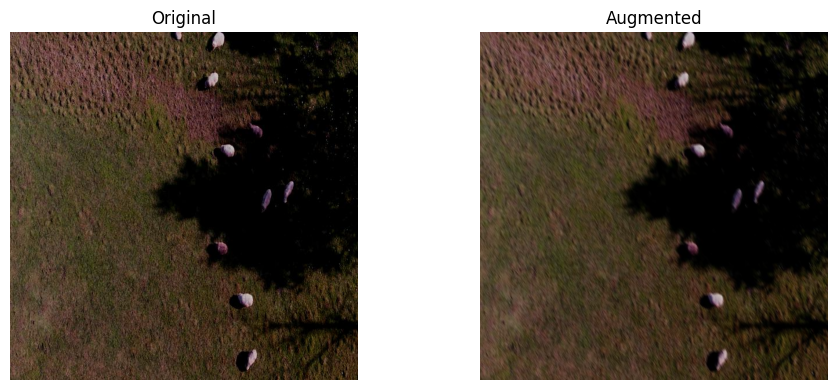

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(augmented["image"])
axes[1].set_title("Augmented")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Preprocessing Summary

The preprocessing pipeline consists of image resizing, normalization, and
data augmentation tailored to the challenges of drone-based wildlife detection.
These steps aim to improve generalization, particularly for small objects and
noisy backgrounds, while preserving annotation consistency.

All preprocessing and augmentation functions are implemented in the `src/data/`
module to ensure modularity, reproducibility, and consistent usage across
training, validation, and evaluation workflows.
